# Processing Journal
## Author: Salvador Antonio Hernández Malavé
## MSc Thesis project: Wetlands monitoring using multi-source multi-temporal and machine learning

Copyright (c) 2022, Salvador Antonio Hernández Malavé.
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import os, subprocess, json
from osgeo import gdal
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix

# bash packages required (outside python): gdal, pkstats

plt.rcParams.update({'font.size': 16})

def stats(l):
    # sample of l = np.array([[0, 0, 0, 0], [0, 29768, 214, 27], [0, 1767, 28216, 183], [0, 278, 383, 29317]])
    producers = [l[1,1]/l[1].sum(), l[2,2]/l[2].sum(), l[3,3]/l[3].sum()]
    users = [l[1,1]/l[:,1].sum(), l[2,2]/l[:,2].sum(), l[3,3]/l[:,3].sum()]
    overall = (l[1,1]+l[2,2]+l[3,3])/sum([l[1].sum(), l[2].sum(), l[3].sum()])
    q = sum([l[1].sum()*l[:,1].sum(), l[2].sum()*l[:,2].sum(), l[3].sum()*l[:,3].sum()])/sum([l[1].sum(), l[2].sum(), l[3].sum()])
    K = (l[1,1] + l[2,2] + l[3,3] - q)/(sum([l[1].sum(), l[2].sum(), l[3].sum()]) - q)
    return(overall, producers, users, K)

counties_num = {
'Stockholms': 1,      
'Uppsala': 3,
'Sodermanlands': 4,
'Ostergotlands': 5,
'Jonkopings': 6,
'Kronobergs': 7,
'Kalmar': 8,
'Gotlands': 9,
'Blekinge': 10,
'Skane': 12,          
'Hallands': 13,
'VastraGotalands': 14,
'Varmlands': 17,
'Orebro': 18,
'Vastmanlands': 19,
'Dalarnas': 20,
'Gavleborgs': 21,
'Vasternorrlands': 22,
'Jamtlands': 23,
'Vasterbottens': 24,
'Norrbottens': 25}

counties_str = {list(counties_num.values())[_]: list(counties_num.keys())[_] for _ in range(len(counties_num))}

#### 1. GEE script requires bboxes for each state, you can do that with the 'Bounding Boxes' in QGIS


#### 2. topographical data derived from the dem is found two ways:

    2.2. TPI is computed using gdaldem (in qgis if you like):
    gdaldem slope /home/salva/proyectos/thesis/data/inputs/gsd2_DEM_stockholms.tif /home/salva/slope2_stockholms.tif -of GTiff -s 1.0
    gdaldem slope /home/salva/proyectos/thesis/data/inputs/gsd2_DEM_jamtlands2.tif /home/salva/slope2_jamtlands.tif -of GTiff -s 1.0
    
    2.2. TPI is computed using gdaldem (in qgis if you like)
    gdaldem TPI /home/salva/proyectos/thesis/data/inputs/gsd2_DEM_stockholms.tif /home/salva/tpi2_stockholms.tif -of GTiff 
    
    2.3. TWI is computed using (grass gis) function r.watershed (can also be done in qgis):
    
    jamtlands:
    r.in.gdal input="/home/salva/proyectos/thesis/data/inputs/gsd2_DEM_jamtlands2.tif" output=raster1 --overwrite -o
    g.region n=6997426.0 s=6963300.0 e=406764.0 w=365362.0 res=2.0
    r.watershed elevation=raster1 convergence=5 tci=tci1 --overwrite
    r.out.gdal -t -m input=tci1 output="/home/salva/twi2_jamtlands.tif" format="GTiff" createopt="TFW=YES,COMPRESS=LZW" --overwrite
    
    stockholm:
    r.in.gdal input="/home/salva/proyectos/thesis/data/inputs/gsd2_stockholms.tif" output=raster2 --overwrite -o
    g.region n=6597500.0 s=6565000.0 e=680000.0 w=645000.0 res=2.0
    r.watershed elevation=raster2 convergence=5 tci=tci2 --overwrite
    r.out.gdal -t -m input=tci2 output="/home/salva/twi2_stockholms.tif" format="GTiff" createopt="TFW=YES,COMPRESS=LZW" --overwrite

#### 3. creating the 10x10 target rasters (0: no-data, 1: non_wetlands, 2: wetlands, 3: water)

    3.1. labeling method 1 (lm1): run results/labeling_method1.sh
    
    3.2. labeling method 2 (lm2): run results/labeling_method2.sh 
    
    NOTE: as you digitize for lm2, you need to be constantly checking the areas, use labeling_method2_areas.sh


#### 4. GEE

    4.1. upload as an asset all rasters, dem, slope, tpi, twi, target10m_l1 & target10m_l2 (NOTE: for the last two set no-data value to 0!!!)
    
    4.2. upload as an asset oversiktskartan prepared sweden_counties (sweden_shp), with the states separated with LANSKOD (this shapefile you created computing in qgis the difference between an_riks and the intersection of an_riks with mh_riks, it will have some odd lines and some odd polygons, fix them manually)
    
    4.3. run script3_final_v2.js for each county, you need to make sure to store:

        4.3.1. confussion matrix & error matrix json's (store in /results/accuracies_feed.xls after cleaning them in the kate, spaces and \n regex), shape: [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
        
        4.3.2. feature importance csv (store in /results/feature_importance_percounty/),
        
        4.3.2. export the classified imagery to google drive

# VMI

In [3]:
# lets check vmi.csv head()
df = pd.read_csv('/home/salva/proyectos/thesis/data/originals/VMI_gpt/VMI.csv')

In [4]:
df.columns

Index(['OBJECTID', 'VERSION', 'LOID', 'OBJNAMN', 'LANKOD', 'PERIMETER',
       'PLANERINGS', 'AREAL_HA', 'AREAL_KVM', 'NVKLASS', 'TPX', 'TPY',
       'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

In [5]:
df['OBJNAMN'].value_counts() 

-1                                                   14
MYR I BJURÄLVENS NATURRESERVAT                        8
MYR VID SVENSKÅN S JÄVSJÖN                            6
MOSSE 8.5 KM NO ÖRKENED                               4
MOSSE 8.5 KM NNV OSBY                                 4
                                                     ..
FUKTÄNG 900 M VSV TORPAREGÄRDE; 2.5 KM NNV LÖT KA     1
EGELKÄRR; 2 KM VSV ALBÖKE KA                          1
MAKARINGEN 3.6 KM SSV ÄLMEBODA KYRKA                  1
NORRESJÖN 7 KM NV SÖDRA SANDSJÖ KYRKA                 1
STOR-RISBÄCKMYRAN 15 KM NO TAVELSJÖ                   1
Name: OBJNAMN, Length: 34453, dtype: int64

In [13]:
def df_reclass(row):
    if type(row) == str:
        if 'MOSSE' in row or 'mosse' in row or 'mossar' in row or 'MOSSAR' in row:
            return 'bog'
        elif 'kärr' in row or 'KÄRR' in row:
            return 'fen'
        elif 'myr' in row or 'MYR' in row:
            return 'mire'
        elif 'våtmarksstrand' in row or 'VÅTMARKSSTRAND' in row:
            return 'marsh'
        else: 
            return 'none'
    else:
        return 0

df['TYPE_SALVA'] = df.apply(lambda row: df_reclass(row['OBJNAMN']), axis=1)

In [14]:
df['TYPE_SALVA'].value_counts() 

none     13353
mire     12060
bog       6960
fen       2220
marsh       21
Name: TYPE_SALVA, dtype: int64

In [50]:
df[['TYPE_SALVA', 'LOID']].to_csv('VMI_reclassified.csv')

In [47]:
pd.set_option("display.max_rows", 60)  # use with care

In [46]:
with pd.option_context("display.max_rows", 1000): # it won't work unless the number is higher than the amount of values... which is 13353
    print(df[df['TYPE_SALVA']=='none']['OBJNAMN'].value_counts())

-1                                                 14
STORA ÖSJÖN 8 KM NV GRIPENBERG                      2
Våtmark 7 km O Jormivaara; 10 km NV Vettasjärvi     2
AUSTERVIKEN; 4000 M OSO NÄR K:A                     2
Vaarajärvenvuoma; 5 km V Kitiöjärvi                 2
                                                   ..
Våtmark SV Stor-blÕliden; 6 km NO Långträsk         1
Våtmark norr Trundön; 17 km NO Piteå                1
Våtmark O RÕlund; 4 km NV Aborrträskl               1
Våtmark N Långträsks kolonat; 3 km N Långträsk      1
HAVSVIK PÅ S BRÄNNÖLANDET 3 KM OSO HOLMSUND         1
Name: OBJNAMN, Length: 13322, dtype: int64


# target rasterization
create the target rasters with a 10m resolution (~9.4 GB)
### labeling method 1 (lm1)

In [ ]:
# ATTENTION: bash code
!gdal_rasterize -l sweden_counties -burn 1.0 -tr 10 10 -init 0.0 -a_nodata 0.0 -ot Byte -of GTiff /home/salva/proyectos/thesis/data/originals/shp/sweden_counties.shp /home/salva/target10m_lm1.tif
!gdal_rasterize -l ms_riks -burn 3.0 /home/salva/proyectos/thesis/data/originals/lantmateriet/Oversiktskartan2021/ms_riks.shp /home/salva/target10m_lm1.tif
!gdal_rasterize -l VMI_ytor -burn 2.0 /home/salva/proyectos/thesis/data/originals/VMI_gpt/VMI_ytor.shp /home/salva/target10m_lm1.tif

### labeling method 2 (lm2)

In [ ]:
# ATTENTION: bash code
!gdal_rasterize -l sweden_counties -burn 0.0 -tr 10 10 -init 0.0 -a_nodata 0.0 -ot Byte -of GTiff /home/salva/proyectos/thesis/data/originals/shp/sweden_counties.shp /home/salva/target10m_lm2.tif
!gdal_rasterize -l lm2_target -a target /home/salva/proyectos/thesis/data/inputs/lm2_target.shp /home/salva/target10m_lm2.tif

# Chapters 1, 2 & 3' statistics

##### ATTENTION 
/results/dict_counties.csv is very important for this step, it has county_VMI, county_good, county_simple, area_sqkm, county_abrev & VMI_area information for each county

In [167]:
# lets check dict_counties.csv head()
fp = '/home/salva/proyectos/thesis/data/results/dict_counties.csv'
df = pd.read_csv(fp)
df

,lanskod,county_VMI,county_good,county_simple,area_sqkm,county_abrev,VMI_area,pct_VMI_coverage
0,1,AB_Stockholm_VMI_Ytor,Stockholms,stockholms,7171.826,AB,147.848719,0.020615
1,3,C_Uppsala_VMI_Ytor,Uppsala,uppsala,8636.762,C,424.170634,0.049112
2,4,D_Södermanland_VMI_Ytor,Södermanlands,sodermanlands,7058.717,D,236.292647,0.033475
3,5,E_Östergötland_VMI_Ytor,Östergötlands,ostergotlands,12281.641,E,262.480241,0.021372
4,6,F_Jonkoping_VMI_Ytor,Jönköpings,jonkopings,11745.475,F,1154.784042,0.098317
5,7,G_Kronoberg_VMI_Ytor,Kronobergs,kronobergs,9426.662,G,1001.382368,0.106229
6,8,H_Kalmar_VMI_Ytor,Kalmar,kalmar,11663.910,H,303.308608,0.026004
7,9,I_Gotland_VMI_Ytor,Gotlands,gotlands,3179.423,I,243.411454,0.076558
8,10,K_Blekinge_VMI_Ytor,Blekinge,blekinge,3046.016,K,166.636382,0.054706
9,12,M_Skåne_VMI_Ytor,Skåne,skane,11362.281,M,114.369867,0.010066


### the count of images (S1 & S2) per county use

In [ ]:
with open('count_gee_percounty.txt', 'r') as f1:
    inputsss = f1.readlines()

i = 0
output = []
temp = []
for line in inputsss:
    if i == 2 or i == 4:
        temp.append(int(line))
    elif i == 5:
        output.append(temp)
        temp = []
        i = 0
    i+=1
output.append(temp) # need to handle last case
pd.DataFrame(output).T.to_csv('count_gee_percounty_output.csv')

### dem info about capturing dates

In [ ]:
fp = '/home/salva/proyectos/thesis/data/results/dem_acquisiton_dates.csv'
df = pd.read_csv(fp)
print(df.describe()) # 23,209 values
print(df['year'].value_counts())

ax = plt.gca()
plt.hist(df)
#ax.set_ylim([min(output['normalized'])-0.002, max(output['normalized'])+0.002])
#plt.xticks(rotation = -45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left')
plt.show()


### dem statistics, max min mean std

In [ ]:
# open raster and choose band to find min, max
raster = '/home/salva/proyectos/thesis/data/inputs/Lantmateriet_National_DEM3006.tif'
gtif = gdal.Open(raster)
srcband = gtif.GetRasterBand(1)

# Get raster statistics
stats = srcband.GetStatistics(True, True)

# Print the min, max, mean, stdev based on stats index
print(f"[ STATS ] =  Minimum={stats[0]:.3f}, Maximum={stats[1]:.3f}, Mean={stats[2]:.3f}, StdDev={stats[3]:.3f}" )

### VMI area, per county

In [ ]:
# we need the area_sqkm per county, after calculating area_sqkm (be aware of the precision digits) for each county
# use field calculator in qgis to calculate area_sqkm and then run:

# ATTENTION: bash code
!qgis_process run qgis:statisticsbycategories --distance_units=meters --area_units=m2 --ellipsoid=EPSG:3006 --INPUT=/home/salva/proyectos/thesis/data/originals/VMI_gpt/VMI_ytor.shp --VALUES_FIELD_NAME=area_sqkm --CATEGORIES_FIELD_NAME=LANSKOD --CATEGORIES_FIELD_NAME=target --OUTPUT=/home/salva/VMI_area_sqkm_statistics_by_group.csv

### koppen geiger
Figure 1 was produced by the script I made for NGEA12, from 2 CMIP6 NC files (pr & ts), then just overlay it with a mask, for display

# Chapter 4 (results) statistics

### Areal Coverage (Targets)

In [5]:
# ATTENTION: bash code
!echo 'labeling method 1 (directly on VMI + Översiktskartan)'
!pkstat -i /home/salva/proyectos/thesis/data/inputs/target10m_lm1.tif -hist -nbins 4
!echo 'labeling method 2 (based on the polygons)'
!pkstat -i /home/salva/proyectos/thesis/data/inputs/target10m_lm2.tif -hist -nbins 4

# NOTE: doesn't work with virtual rasters (vrt) !

labeling method 1 (directly on VMI + Översiktskartan)
0 5547426950
1 3701211831
2 431616521
3 366623006
labeling method 2 (based on the polygons)
0 1.003575052e+10
1 3730312
2 1243089
3 6154386


In [77]:
sum1 = 3701211831+431616521+366623006
print('lm1 pct: ', 3701211831/sum1,431616521/sum1,366623006/sum1)
print('lm2 pct: ', 3730312/sum1,1243089/sum1,6154386/sum1)

lm1 pct:  0.8225918087589202 0.09592647784325709 0.08148171339782267
lm2 pct:  0.000829059301500732 0.00027627568365414033 0.001367808097104447


In [75]:
print('lm1')
print('non_wetlands: ', 3701211831*100/1000000, ' sqkm')
print('wetlands: ', 431616521*100/1000000, ' sqkm')
print('water: ', 366623006*100/1000000, ' sqkm')

print('\nlm2')
print('non_wetlands: ', 3730312*100/1000000, ' sqkm')
print('wetlands: ', 1243089*100/1000000, ' sqkm')
print('water: ', 6154386*100/1000000, ' sqkm')

lm1
non_wetlands:  370121.1831  sqkm
wetlands:  43161.6521  sqkm
water:  36662.3006  sqkm

lm2
non_wetlands:  373.0312  sqkm
wetlands:  124.3089  sqkm
water:  615.4386  sqkm


### Areal Coverage (Classifications) (lm1 & lm2)

In [35]:
#ATTENTION: bash code

#lets check if every raster has the same resolution

!for i in /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/*.tif; do gdalinfo $i | grep -E 'Files|Pixel'; done

Files: /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/Blekinge_run59609_lm1_classified10.tif
Pixel Size = (10.000000000000000,-10.000000000000000)
Files: /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/Dalarnas_run59604_lm1_classified10.tif
Pixel Size = (10.000000000000000,-10.000000000000000)
Files: /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/Gavleborgs_run59602_lm1_classified10.tif
Pixel Size = (10.000000000000000,-10.000000000000000)
Files: /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/Gotlands_run59610_lm1_classified10.tif
Pixel Size = (10.000000000000000,-10.000000000000000)
Files: /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/Hallands_run59607_lm1_classified10.tif
Pixel Size = (10.000000000000000,-10.000000000000000)
Files: /home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/Jamtlands_run59601_lm1_classified10-0000000000-0000000000.tif
Pixel Size = (10.000000000000000,-10.000000000000000)
Files: /home/sa

In [158]:
fp = "/home/salva/proyectos/thesis/data/rasters/classified_V2_lm1/"
l1 = pathlib.Path(fp).glob('*.tif')

output_df = pd.DataFrame(columns = range(4))

for f in l1:
    print(f.stem)
    output = subprocess.check_output('pkstat -i ' + str(f) + ' -hist -nbins 4', shell=True) # no servia de llamandolo tipo !pkstat, os.system tambien sirve pero no retreive el resultado
    out_str = str(output).split("'")[1]
    out_array = np.array([_.split(' ') for _ in out_str.split('\\n')[:-1]])
    if out_array[:,1].size == 4:
        output_df = pd.concat([output_df, pd.DataFrame([out_array[:,1]], index = [f.stem.split('_')[0]], columns = [0,1,2,3])])
        print('OK')
    else: 
        print(out_array)
    print('')

#output_df['valid'] = output_df[]
print(output_df)
output_df.to_csv('pixelcount_' + pathlib.Path(fp).stem + '.csv')

Skane_run59607_lm1_classified10
OK

Vasternorrlands_run59871_lm1_classified10
OK

Hallands_run59607_lm1_classified10
OK

Norrbottens4_run59866_lm1_classified10-0000000000-0000000000
OK

Orebro_run59605_lm1_classified10
OK

Vasterbottens2_run59601_lm1_classified10-0000032768-0000000000
OK

Jamtlands1_run59601_lm1_classified10-0000032768-0000000000
OK

Vastmanlands_run59604_lm1_classified10
OK

Jonkopings_run59617_lm1_classified10
OK

Jamtlands2_run59601_lm1_classified10-0000000000-0000000000
OK

Kalmar_run59610_lm1_classified10
OK

Varmlands_run59606_lm1_classified10
OK

Uppsala_run59962_lm1_classified10
OK

Norrbottens2_run59866_lm1_classified10-0000032768-0000000000
OK

Vasterbottens3_run59601_lm1_classified10-0000000000-0000032768
OK

Kronobergs_run59617_lm1_classified10
OK

Blekinge_run59609_lm1_classified10
OK

Norrbottens3_run59866_lm1_classified10-0000000000-0000032768
OK

Dalarnas_run59604_lm1_classified10
OK

Ostergotlands_run59626_lm1_classified10
OK

Gavleborgs_run59602_lm1_c

In [162]:
fp = "/home/salva/proyectos/thesis/data/rasters/classified_V2_lm2/"
l1 = pathlib.Path(fp).glob('*.tif')

output_df = pd.DataFrame(columns = range(4))

for f in l1:
    print(f.stem)
    output = subprocess.check_output('pkstat -i ' + str(f) + ' -hist -nbins 4', shell=True) # no servia de llamandolo tipo !pkstat, os.system tambien sirve pero no retreive el resultado
    out_str = str(output).split("'")[1]
    out_array = np.array([_.split(' ') for _ in out_str.split('\\n')[:-1]])
    if out_array[:,1].size == 4:
        output_df = pd.concat([output_df, pd.DataFrame([out_array[:,1]], index = [f.stem.split('_')[0]], columns = [0,1,2,3])])
        print('OK')
    else: 
        print(out_array)
    print('')

#output_df['valid'] = output_df[]
print(output_df)
output_df.to_csv('pixelcount_' + pathlib.Path(fp).stem + '.csv')

Kalmar_run61429_lm2_classified10
OK

Gotlands_run61429_lm2_classified10
OK

Jamtlands_run61172_lm2_classified10-0000000000-0000000000
OK

Norrbottens_run61095_lm2_classified10-0000032768-0000000000
OK

Vasterbottens_run61172_lm2_classified10-0000032768-0000000000
OK

Ostergotlands_run61539_lm2_classified10
OK

Vasterbottens_run61172_lm2_classified10-0000000000-0000032768
OK

Dalarnas_run61350_lm2_classified10
OK

Vasterbottens_run61172_lm2_classified10-0000000000-0000000000
OK

Blekinge_run61428_lm2_classified10
OK

Norrbottens_run61095_lm2_classified10-0000000000-0000032768
OK

Orebro_run61370_lm2_classified10
OK

Jonkopings_run61531_lm2_classified10
OK

Vasternorrlands_run61173_lm2_classified10
OK

Jamtlands_run61172_lm2_classified10-0000032768-0000000000
OK

Vastmanlands_run61369_lm2_classified10
OK

Sodermanlands_run61540_lm2_classified10
OK

Norrbottens_run61095_lm2_classified10-0000032768-0000032768
OK

Varmlands_run61370_lm2_classified10
OK

VastraGotalands_run61370_lm2_classifi

### GLWD-3 (Global lakes and wetlands database)

In [1]:
!pkstat -i /home/salva/proyectos/thesis/data/originals/GLWD/glwd3_sweden.tif -hist -nbins 5
# 1,2,3 == water
#   4,8 == wetlands
#   255 == no-data


1 69599
2 1129
3 351
4 46352
5 0
6 0
7 0
8 26
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
18

In [2]:
!gdalinfo /home/salva/proyectos/thesis/data/originals/GLWD/glwd3_sweden.tif | grep -E 'Files|Pixel'

Files: /home/salva/proyectos/thesis/data/originals/GLWD/glwd3_sweden.tif
Pixel Size = (663.038954703696049,-663.144151000842385)


In [5]:
print((69599+1129+351)*663.038954703696049*663.144151000842385/1000000, 'sqkm')
print((46352+26)*663.038954703696049*663.144151000842385/1000000, 'sqkm')

31252.754275491363 sqkm
20391.961589059192 sqkm


### Areal Coverage (MODIS)

In [3]:
# modis lc1 raster was clipped using 'clip raster by mask layer' in QGIS, then we have a tif per county
modis_dict_lanskod = {0:19,1:10,2:5,3:3,4:22,5:12,6:21,7:23,8:25,9:1,10:4,11:7,12:13,13:9,14:14,15:8,16:20,17:24,18:17,19:6,20:18}

In [26]:
fp = "/home/salva/proyectos/thesis/data/rasters/MODIS_per_county/"
l1 = pathlib.Path(fp).glob('*.tif')

output_df = pd.DataFrame()

for f in l1:
    lanskod = modis_dict_lanskod[int(f.stem.split('_')[1])]
    county = counties_str[lanskod]
    print(f.stem, county)
    output = subprocess.check_output('pkstat -i ' + str(f) + ' -hist -nbins 4', shell=True) # no servia de llamandolo tipo !pkstat, os.system tambien sirve pero no retreive el resultado
    out_str = str(output).split("'")[1]
    
    out_array = np.array([_.split(' ') for _ in out_str.split('\\n')[:-1]]+[['999', f.stem.split('_')[1]]])
    if out_array[:,1].size == 5:
        output_df = pd.concat([output_df, pd.DataFrame([out_array[:,1]], index = [county], columns = [0,1,2,3,'raster_n'])])
        print('OK')
    else: 
        print(out_array)
    print('')

output_df['lanskod'] = output_df.apply(lambda row: counties_num[row.name], axis=1)

#output_df['valid'] = output_df[]
print(output_df)
output_df.to_csv('pixelcount_' + pathlib.Path(fp).stem + '.csv')

raster_3 Uppsala
OK

raster_0 Vastmanlands
OK

raster_19 Jonkopings
OK

raster_9 Stockholms
OK

raster_16 Dalarnas
OK

raster_2 Ostergotlands
OK

raster_12 Hallands
OK

raster_17 Vasterbottens
OK

raster_10 Sodermanlands
OK

raster_8 Norrbottens
OK

raster_15 Kalmar
OK

raster_1 Blekinge
OK

raster_14 VastraGotalands
OK

raster_4 Vasternorrlands
OK

raster_11 Kronobergs
OK

raster_20 Orebro
OK

raster_13 Gotlands
OK

raster_7 Jamtlands
OK

raster_6 Gavleborgs
OK

raster_5 Skane
OK

raster_18 Varmlands
OK

                      0       1      2      3 raster_n  lanskod
Uppsala           62361   59431    638   2428        3        3
Vastmanlands      29415   37284    550   2717        0       19
Jonkopings        75359   75911    159   4400       19        6
Stockholms       115664   44543   2154   4715        9        1
Dalarnas         271233  220973    462   5214       16       20
Ostergotlands     75022   76421    763   8451        2        5
Hallands          69639   37957    228   

In [37]:
#ATTENTION: bash code

#lets check if every raster has the same resolution

!for i in /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/*.tif; do gdalinfo $i | grep -E 'Files|Pixel'; done

Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_0.tif
Pixel Size = (374.019363247863566,-374.866147157194121)
Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_10.tif
Pixel Size = (377.014894080997124,-376.276052980134807)
Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_11.tif
Pixel Size = (385.847932668329349,-385.536732283464858)
Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_12.tif
Pixel Size = (383.324806896551365,-383.779951871656635)
Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_13.tif
Pixel Size = (380.327033653845263,-380.188417977529980)
Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_14.tif
Pixel Size = (377.570335051546579,-377.505751987279552)
Files: /home/salva/proyectos/thesis/data/rasters/MODIS_per_county/raster_15.tif
Pixel Size = (381.534419463087204,-381.939557319224491)
Files: /home/salva/proyectos/thesis/data/rasters/

In [54]:
result_parsed = [0,374.019363247863566,-374.866147157194121,10,377.014894080997124,-376.276052980134807,11,385.847932668329349,-385.536732283464858,12,383.324806896551365,-383.779951871656635,13,380.327033653845263,-380.188417977529980,14,377.570335051546579,-377.505751987279552,15,381.534419463087204,-381.939557319224491,16,366.182202682563229,-366.030494609163611,17,344.855074950690323,-344.894419633225823,18,370.623724056603862,-370.475852062589183,19,381.850640586797226,-382.078690288713062,1,388.758535580525120,-388.175120253174839,20,375.398545454545001,-374.875342528736098,2,378.746414043583741,-378.416089974291083,3,371.536411042944394,-371.906592689294087,4,357.939698540370841,-358.507629307218167,5,387.931340175952926,-387.877938416417805,6,365.583207792207645,-365.789168453294735,7,354.648273109243632,-354.660877350045780,8,327.698202310577983,-327.494708428530373,9,373.038442577030594,-373.072243589742698]
result_nparray = np.array(result).reshape(21,3)
result_nparray[:,2] = -result_nparray[:,2]

In [56]:
df_trying = pd.DataFrame(result_nparray, columns=['raster_n','x','y'])

df_trying['lanskod'] = df_trying.apply(lambda row: modis_dict_lanskod[row[0]], axis=1)
print(df_trying)
df_trying.to_csv('pixelsize_MODIS.csv')

    raster_n           x           y  lanskod
0        0.0  374.019363  374.866147       19
1       10.0  377.014894  376.276053        4
2       11.0  385.847933  385.536732        7
3       12.0  383.324807  383.779952       13
4       13.0  380.327034  380.188418        9
5       14.0  377.570335  377.505752       14
6       15.0  381.534419  381.939557        8
7       16.0  366.182203  366.030495       20
8       17.0  344.855075  344.894420       24
9       18.0  370.623724  370.475852       17
10      19.0  381.850641  382.078690        6
11       1.0  388.758536  388.175120       10
12      20.0  375.398545  374.875343       18
13       2.0  378.746414  378.416090        5
14       3.0  371.536411  371.906593        3
15       4.0  357.939699  358.507629       22
16       5.0  387.931340  387.877938       12
17       6.0  365.583208  365.789168       21
18       7.0  354.648273  354.660877       23
19       8.0  327.698202  327.494708       25
20       9.0  373.038443  373.0722

In [135]:
# ATTENTION: bash code
!echo 'MODIS PIXEL COUNT'
!pkstat -i /home/salva/proyectos/thesis/data/rasters/MODIS_LC1.tif -hist -nbins 4

MODIS PIXEL COUNT
1 5796263
2 94552
3 3415053


In [51]:
print('MODIS LC1:')
print(5796263*375*375/1000000, 'sqkm of non-wetlands')
print(94552*375*375/1000000, 'sqkm of wetlands')
print(3415053*375*375/1000000, 'sqkm of inland water')

#Note the coverage greatly higher than supposed to be...

MODIS LC1:
815099.484375 sqkm of non-wetlands
13296.375 sqkm of wetlands
480241.828125 sqkm of inland water


### Accuracy / Accuracies
##### after you have all items from step 3, first thing calculate the accuracies

In [4]:
# metodo original

output = pd.DataFrame(columns = range(12))

per_class_producers1 = np.zeros((21,3))
per_class_users1 = np.zeros((21,3))
per_class_producers2 = np.zeros((21,3))
per_class_users2 = np.zeros((21,3))

fp = "/home/salva/proyectos/thesis/data/results/acc_V2_lm1/"
l1 = pathlib.Path(fp).glob('*.csv')
i = 0
for f in l1:
    print(f)
    with open(f.as_posix(), 'r') as f1:
        df = pd.read_csv(f1)
        l_training = np.array(json.loads(df['trainConfussionMatrix'].iloc[0])) # igualito a una de las columnas de accuracies.ods
        l_validation = np.array(json.loads(df['validationErrorMatrix'].iloc[0]))
        
    overall1, producers1, users1, K1 = stats(l_training)
    overall2, producers2, users2, K2 = stats(l_validation)

    out_temp1 = [np.around(overall1*100, 2), np.around(np.array(producers1).mean()*100, 2), np.around(np.array(users1).mean()*100, 2), np.around(K1, 4)]
    out_temp2 = [np.around(overall2*100, 2), np.around(np.array(producers2).mean()*100, 2), np.around(np.array(users2).mean()*100, 2), np.around(K2, 4)]
    out_temp3 = [str(np.around(np.array(producers1)*100, 2)), str(np.around(np.array(users1)*100, 2)), str(np.around(np.array(producers2)*100, 2)), str(np.around(np.array(users2)*100, 2))]

    output.loc[i] = out_temp1 + out_temp2 + out_temp3

    per_class_producers1[i] = np.array(producers1)*100
    per_class_users1[i] = np.array(users1)*100
    per_class_producers2[i] = np.array(producers2)*100
    per_class_users2[i] = np.array(users2)*100
    i+=1

print('average')
print('training producers accuracy', np.around(per_class_producers1.mean(axis=0), 2))
print('training     users accuracy', np.around(per_class_users1.mean(axis=0), 2))
print(' testing producers accuracy', np.around(per_class_producers2.mean(axis=0), 2))
print(' testing     users accuracy', np.around(per_class_users2.mean(axis=0), 2))

output.to_csv(pathlib.Path(fp).stem + '_output.csv')
pass

/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Uppsala_run59962_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Ostergotlands_run59626_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Dalarnas_run59604_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Varmlands_run59606_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Sodermanlands_run59635_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Stockholms_run59647_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Norrbottens_run59866_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Gotlands_run59610_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Vastmanlands_run59604_lm1_accuracyMatrices.csv
/home/salva/proyectos/thesis/data/results/acc_V2_lm1/Vasternorrlands_run59871_lm1_accuracyMatrices.csv
/home/salva/pr

In [72]:
# para toda suecia es mejor sumar todas las matrices!:
def sve_acc(l1):
    sve_training = np.zeros((4,4))
    sve_validation = np.zeros((4,4))

    for f in l1:
        #print(f)
        with open(f.as_posix(), 'r') as f1:
            df = pd.read_csv(f1)
            l_training = np.array(json.loads(df['trainConfussionMatrix'].iloc[0])) # igualito a una de las columnas de accuracies.ods
            l_validation = np.array(json.loads(df['validationErrorMatrix'].iloc[0]))

        sve_training += l_training
        sve_validation += l_validation

    print(pathlib.Path(fp).stem,'\n')

    overall1, producers1, users1, K1 = stats(sve_training)
    overall2, producers2, users2, K2 = stats(sve_validation)

    out_temp1 = [np.around(overall1*100, 2), np.around(np.array(producers1).mean()*100, 2), np.around(np.array(users1).mean()*100, 2), np.around(K1, 4)]
    out_temp2 = [np.around(overall2*100, 2), np.around(np.array(producers2).mean()*100, 2), np.around(np.array(users2).mean()*100, 2), np.around(K2, 4)]
    out_temp3 = [str(np.around(np.array(producers1)*100, 2)), str(np.around(np.array(users1)*100, 2)), str(np.around(np.array(producers2)*100, 2)), str(np.around(np.array(users2)*100, 2))]

    print('training OA,producers,users,K: ',out_temp1)
    print('validation OA,producers,users,K: ',out_temp2)
    print('per class training_producers, training_users, validation_producers, validation_users\n',out_temp3)

    per_class_producers1 = np.array(producers1)*100
    per_class_users1 = np.array(users1)*100
    per_class_producers2 = np.array(producers2)*100
    per_class_users2 = np.array(users2)*100

    print('\naverage')
    print('training producers accuracy', np.around(per_class_producers1.mean(axis=0), 2))
    print('training     users accuracy', np.around(per_class_users1.mean(axis=0), 2))
    print(' testing producers accuracy', np.around(per_class_producers2.mean(axis=0), 2))
    print(' testing     users accuracy', np.around(per_class_users2.mean(axis=0), 2))

    #output.to_csv(pathlib.Path(fp).stem + '_output.csv')


l1 = pathlib.Path('/home/salva/proyectos/thesis/data/results/acc_V2_lm1/').glob('*.csv')
sve_acc(l1)

print('\n')
l2 = pathlib.Path('/home/salva/proyectos/thesis/data/results/acc_V2_lm2/').glob('*.csv')
sve_acc(l2)

acc_V2_lm1 

training OA,producers,users,K:  [99.37, 99.38, 99.38, 0.9906]
validation OA,producers,users,K:  [82.25, 82.46, 82.42, 0.7335]
per class training_producers, training_users, validation_producers, validation_users
 ['[99.56 98.82 99.76]', '[99.13 99.42 99.6 ]', '[82.54 72.08 92.77]', '[79.31 75.56 92.4 ]']

average
training producers accuracy 99.38
training     users accuracy 99.38
 testing producers accuracy 82.46
 testing     users accuracy 82.42


acc_V2_lm1 

training OA,producers,users,K:  [99.96, 99.96, 99.96, 0.9994]
validation OA,producers,users,K:  [98.97, 98.97, 98.97, 0.9846]
per class training_producers, training_users, validation_producers, validation_users
 ['[ 99.93  99.95 100.  ]', '[ 99.95  99.93 100.  ]', '[98.3  98.65 99.96]', '[98.63 98.31 99.99]']

average
training producers accuracy 99.96
training     users accuracy 99.96
 testing producers accuracy 98.97
 testing     users accuracy 98.97


In [73]:
sve_validation

array([[     0.,      0.,      0.,      0.],
       [     0., 207882.,  42867.,   1104.],
       [     0.,  51346., 174467.,  16246.],
       [     0.,   2874.,  13552., 210793.]])

### Feature importance

B2_summer2021      0.088652
B3_summer2021      0.086789
B4_summer2021      0.086729
B8_summer2021      0.088804
NDVI_summer2021    0.088903
NDWI_summer2021    0.089706
VH_summer2021      0.094109
VV_summer2021      0.093678
slope              0.094248
tpi                0.093294
twi                0.095088
Name: normalized, dtype: float64
output generated


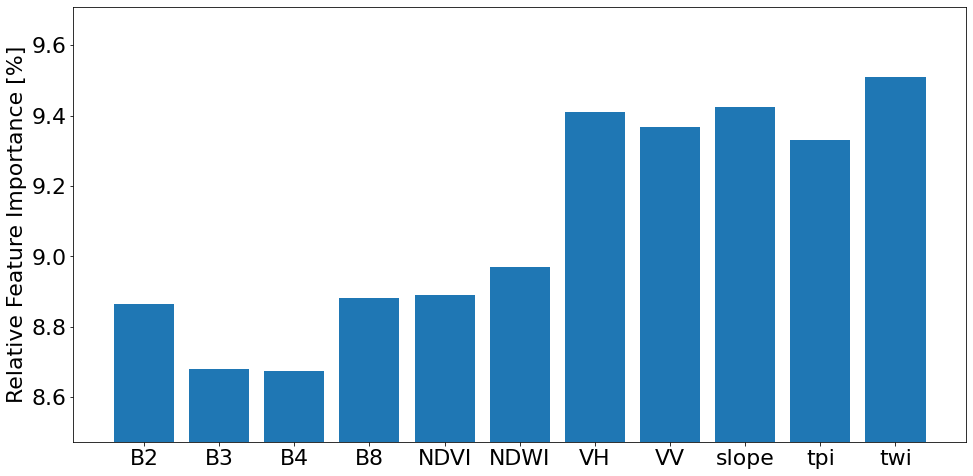

In [4]:
i = 0
fp = "/home/salva/proyectos/thesis/data/results/fi_V2_lm1/"
l1 = pathlib.Path(fp).glob('*.csv')
#print(next(l1))
for f in l1:
    with open(f.as_posix(), 'r') as f1:
        #print(f)
        df = pd.read_csv(f1, index_col=False)
        df = df[[_ for _ in df.columns if _ not in ['system:index','.geo']]].T
        df.columns = ['fi']
        if i == 0:
            i += 1
            values = df['fi'] # .apply(lambda row: float(row.replace(',','')))
        else:
            values = values + df['fi'] # .apply(lambda row: float(row.replace(',','')))

bands = [_.replace('_summer2021','') for _ in list(df.index)]

df['normalized'] = values/values.sum()
print(df['normalized'])
df.to_csv(pathlib.Path(fp).stem + '_sum_normalized.csv')
print('output generated')

plt.figure(figsize=(16, 8))
ax = plt.gca()
plt.bar(bands,df['normalized']*100)
ax.set_ylim([min(df['normalized']*100)-0.2, max(df['normalized']*100)+0.2])
#plt.xticks(rotation = 90)
#plt.setp(ax.xaxis.get_majorticklabels(), ha='left')
#plt.title(pathlib.Path(fp).stem)
#plt.xlabel('inputs')
plt.ylabel('Relative Feature Importance [%]')
plt.show()

### Data from labeled samples

In [2]:
fp1 = '/home/salva/proyectos/thesis/data/results/lm1_stratifiedsamples.csv'
fp2 = '/home/salva/proyectos/thesis/data/results/lm2_stratifiedsamples.csv'

df1 = pd.read_csv(fp1)
df2 = pd.read_csv(fp2)

df1.columns = [_.replace('_summer2021','') for _ in df1.columns]
df2.columns = [_.replace('_summer2021','') for _ in df2.columns]

non_wetlands1 = df1[(df1['target']==1)]
wetlands1 = df1[(df1['target']==2)]
water1 = df1[(df1['target']==3)]

non_wetlands2 = df2[(df2['target']==1)]
wetlands2 = df2[(df2['target']==2)]
water2 = df2[(df2['target']==3)]

In [4]:
print('labeling method 1', [_.shape for _ in [df1, non_wetlands1, wetlands1, water1]])
print('labeling method 2', [_.shape for _ in [df2, non_wetlands2, wetlands2, water2]])

labeling method 1 [(1802896, 17), (630000, 17), (605638, 17), (567258, 17)]
labeling method 2 [(1889593, 17), (630000, 17), (629593, 17), (630000, 17)]


In [8]:
pd.get_option("display.max_columns")

In [9]:
pd.set_option("display.max_columns", None)

In [10]:
#pd.set_option("display.max_rows", None)  # use with care

In [143]:
df1.head()

,system:index,B2,B3,B4,B8,NDPI,NDVI,NDWI,VH,VV,dem,lanskod,slope,target,tpi,twi,.geo
0,0_0,348.5,508.5,371.0,2918.5,-0.262811,0.774434,-0.703239,-15.839008,-9.246314,19.499655,1,1.689780,1,-0.363830,10.418894,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,0_1,277.0,515.5,296.5,3360.0,-0.218816,0.837823,-0.733970,-17.140199,-10.985784,2.952128,1,2.311256,1,-0.608626,8.978459,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,0_2,194.5,317.5,210.5,1809.5,-0.244323,0.791584,-0.701457,-15.984844,-9.707583,37.644894,1,2.964492,1,-0.359562,9.449129,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,0_3,212.5,367.0,257.0,1990.5,-0.247884,0.771301,-0.688653,-14.629898,-8.817626,59.827175,1,1.184089,1,0.026990,8.564663,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,0_4,298.5,505.0,356.0,2862.5,-0.234252,0.778779,-0.700074,-13.070731,-8.109280,18.447176,1,2.751457,1,0.271757,7.234064,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [144]:
df2.head()

,system:index,B2,B3,B4,B8,NDPI,NDVI,NDWI,VH,VV,dem,lanskod,slope,target,tpi,twi,.geo
0,0_0,192.0,338.0,254.0,1930.0,-0.202027,0.767399,-0.701940,-16.964107,-11.261735,52.581040,1,4.148076,1,-0.292231,7.028641,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,0_1,884.0,1040.0,1198.0,1322.0,-0.440527,0.049206,-0.119390,-13.884685,-5.392548,30.597530,1,2.994388,1,-0.124238,6.910197,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,0_2,220.0,323.0,225.0,2070.0,-0.219419,0.803922,-0.730046,-16.428698,-10.516422,36.542290,1,2.256537,1,-0.552036,8.647023,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,0_3,1234.0,1334.0,1604.0,2186.0,-0.294593,0.153562,-0.242045,-20.711861,-11.285613,42.633633,1,2.141464,1,1.708164,5.811872,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,0_4,538.0,842.0,768.0,3120.0,-0.237899,0.604938,-0.574962,-17.382971,-10.701663,47.923460,1,2.144977,1,-0.298742,8.609818,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [145]:
df1.describe()

,B2,B3,B4,B8,NDPI,NDVI,NDWI,VH,VV,dem,lanskod,slope,target,tpi,twi
count,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06,1.802896e+06
mean,2.622049e+02,3.895228e+02,2.894647e+02,1.798789e+03,-2.113006e-01,5.300986e-01,-4.348290e-01,-1.915518e+01,-1.291729e+01,1.685673e+02,1.355145e+01,1.700273e+00,1.965199e+00,-7.787283e-02,1.234709e+01
std,1.152268e+02,1.875819e+02,1.843338e+02,1.206596e+03,1.398190e-01,3.779516e-01,4.075004e-01,4.927672e+00,4.965479e+00,1.731311e+02,7.545147e+00,2.347109e+00,8.141647e-01,4.479564e-01,4.974243e+00
min,1.600000e+01,1.700000e+01,1.000000e+00,1.000000e+00,-8.550564e+01,-9.939940e-01,-8.827333e-01,-2.915177e+01,-2.481816e+01,-4.248513e+01,1.000000e+00,0.000000e+00,1.000000e+00,-1.164114e+01,3.581580e+00
25%,1.935000e+02,2.675000e+02,1.750000e+02,2.410000e+02,-2.527515e-01,2.413764e-01,-7.085231e-01,-2.423738e+01,-1.778402e+01,4.430000e+01,7.000000e+00,2.225594e-01,1.000000e+00,-2.068969e-01,8.656634e+00
50%,2.425000e+02,3.850000e+02,2.460000e+02,2.109000e+03,-2.208797e-01,7.215998e-01,-6.571429e-01,-1.694851e+01,-1.047656e+01,1.173407e+02,1.300000e+01,9.178690e-01,2.000000e+00,-2.869141e-02,1.066883e+01
75%,3.055000e+02,4.930000e+02,3.590000e+02,2.664000e+03,-1.578505e-01,8.026316e-01,-1.382393e-01,-1.518103e+01,-9.269174e+00,2.349101e+02,2.000000e+01,2.264484e+00,3.000000e+00,1.325735e-02,1.505493e+01
max,6.428000e+03,6.384000e+03,6.185000e+03,6.545000e+03,8.737995e+01,9.479402e-01,9.962193e-01,8.764564e+00,2.058673e+01,1.948324e+03,2.500000e+01,5.786194e+01,3.000000e+00,1.255614e+01,3.032018e+01


In [146]:
df2.describe()

,B2,B3,B4,B8,NDPI,NDVI,NDWI,VH,VV,dem,lanskod,slope,target,tpi,twi
count,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06,1.889593e+06
mean,3.623382e+02,4.984662e+02,4.460175e+02,1.778145e+03,-2.316931e-01,3.828706e-01,-3.127062e-01,-2.089230e+01,-1.400064e+01,1.479181e+02,1.338168e+01,1.175283e+00,2.000000e+00,-1.935507e-04,1.363689e+01
std,2.288020e+02,2.925200e+02,3.366391e+02,1.331702e+03,1.149606e+01,3.838379e-01,4.338787e-01,4.962217e+00,5.785265e+00,2.067670e+02,7.429513e+00,3.197456e+00,8.165847e-01,6.044471e-01,5.674851e+00
min,1.000000e+00,2.400000e+01,2.400000e+01,1.000000e+00,-1.298295e+04,-9.848485e-01,-8.781261e-01,-2.914742e+01,-2.557814e+01,-4.746136e+01,1.000000e+00,0.000000e+00,1.000000e+00,-3.596579e+01,2.875378e+00
25%,2.150000e+02,2.735000e+02,1.735000e+02,1.420000e+02,-2.761016e-01,3.728814e-02,-6.673027e-01,-2.660659e+01,-2.084404e+01,2.662657e+01,7.000000e+00,0.000000e+00,1.000000e+00,-3.367590e-02,9.228609e+00
50%,3.135000e+02,4.965000e+02,3.875000e+02,2.092000e+03,-2.129089e-01,5.497202e-01,-5.641646e-01,-1.998729e+01,-1.185564e+01,7.542388e+01,1.300000e+01,1.703695e-01,2.000000e+00,0.000000e+00,1.152848e+01
75%,4.165000e+02,6.500000e+02,6.155000e+02,2.774000e+03,-1.279307e-01,7.028571e-01,1.060359e-01,-1.705583e+01,-9.844657e+00,1.655179e+02,2.000000e+01,8.990392e-01,3.000000e+00,1.622392e-02,1.913450e+01
max,7.048000e+03,7.332000e+03,8.210000e+03,8.268000e+03,5.668171e+03,9.552027e-01,9.932432e-01,1.463829e+01,2.443984e+01,1.680955e+03,2.500000e+01,5.985017e+01,3.000000e+00,2.435621e+01,3.110350e+01


In [13]:
not_numerical = [_ for _ in df.columns if _ not in df.describe().columns] # if var in describe = is numerical

In [14]:
not_numerical

['system:index', '.geo']

In [15]:
df[not_numerical].head()

,system:index,.geo
0,0_0,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,0_1,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,0_2,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,0_3,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,0_4,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [130]:
df2['lanskod'].value_counts() 

1     90000
14    90000
24    90000
23    90000
22    90000
21    90000
20    90000
19    90000
18    90000
17    90000
13    90000
3     90000
12    90000
9     90000
8     90000
7     90000
6     90000
5     90000
4     90000
25    90000
10    89593
Name: lanskod, dtype: int64

In [131]:
df2['lanskod'].unique() 

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 17, 18, 19, 20, 21,
       22, 23, 24, 25])

### Plots (comparing statistics between classes)

In [4]:
# https://stackabuse.com/matplotlib-violin-plot-tutorial-and-examples/
# https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py

class_labels = ['non-wetlands', 'wetlands', 'water']

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')

def plot_compare_counties(var, d, lm, expert=False, top=None, bottom=None):
    datasets = [d[d['lanskod'] == _][var] for _ in df1['lanskod'].unique()]
    fig, ax = plt.subplots(figsize=(16, 5))
    parts = ax.violinplot(datasets,showmeans=False,showmedians=False,showextrema=False) # [12,7,14,20,25]
    ax.set_title('Violin Plot: ' + var + ' (labeling method ' + lm + ')')
    ax.set_ylabel(var)
    set_axis_style(ax, [counties_str[_] for _ in list(counties_num.values())])
    plt.xticks(rotation = -45)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='left')
    for part in parts['bodies']: 
        part.set_facecolor('#cdb354')
        part.set_edgecolor('black')
        part.set_alpha(1)
    
    quartile1 = [np.percentile(_, 25, axis=0) for _ in datasets]
    medians = [np.percentile(_, 50, axis=0) for _ in datasets]
    quartile3 = [np.percentile(_, 75, axis=0) for _ in datasets]

    whiskers = np.array([adjacent_values(ds, q1, q3) for ds, q1, q3 in zip(datasets, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='_', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    if top != None or bottom != None:
        ax.set_ylim(top=top, bottom=bottom)
    le = [Line2D([0], [0], marker='o', color='w', label='Wetlands', markerfacecolor='#cdb354', markersize=15, mec='k', mew='1')]
    ax.legend(handles=le, loc='upper right')
    plt.show()    

def plot_compare_classes(lm, var):
    if lm == 'lm1':
        class1, class2, class3 = non_wetlands1, wetlands1, water1
    elif lm == 'lm2':
        class1, class2, class3 = non_wetlands2, wetlands2, water2
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.violinplot([class1[var], class2[var], class3[var]])
    ax.set_title('Violin Plot: ' + var + ' ' + lm)
    set_axis_style(ax, class_labels)
    plt.show()

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals.max())
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals.min(), q1)
    return lower_adjacent_value, upper_adjacent_value

def plot_compare_lm(var, expert=False, top=None, bottom=None):
    datasets = [non_wetlands1[var],non_wetlands2[var],wetlands1[var],wetlands2[var],water1[var],water2[var]]
    
    fig, ax = plt.subplots(figsize=(16, 5))
    
    parts = ax.violinplot(datasets,showmeans=False,showmedians=False,showextrema=False)
    for pc in parts['bodies']:
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    parts['bodies'][0].set_facecolor('#BEBEBE')
    parts['bodies'][1].set_facecolor('#BEBEBE')
    parts['bodies'][2].set_facecolor('#cdb354')
    parts['bodies'][3].set_facecolor('#cdb354')
    parts['bodies'][4].set_facecolor('#50bbdf')
    parts['bodies'][5].set_facecolor('#50bbdf')

    quartile1 = [np.percentile(_, 25, axis=0) for _ in datasets]
    medians = [np.percentile(_, 50, axis=0) for _ in datasets]
    quartile3 = [np.percentile(_, 75, axis=0) for _ in datasets]

    whiskers = np.array([adjacent_values(ds, q1, q3) for ds, q1, q3 in zip(datasets, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='_', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    ax.set_ylabel(var)
    set_axis_style(ax, ['1','2','1','2','1','2'])
    
    if top != None or bottom != None:
        ax.set_ylim(top=top, bottom=bottom)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Non-wetlands', markerfacecolor='#BEBEBE', markersize=15, mec='k', mew='1'),
                       Line2D([0], [0], marker='o', color='w', label='Wetlands', markerfacecolor='#cdb354', markersize=15, mec='k', mew='1'),
                       Line2D([0], [0], marker='o', color='w', label='Water', markerfacecolor='#50bbdf', markersize=15, mec='k', mew='1')]
    ax.set_xlabel('Labeling Method')
    ax.legend(handles=legend_elements, loc='upper right')
    if not expert:
        plt.show()
    else:
        return ax

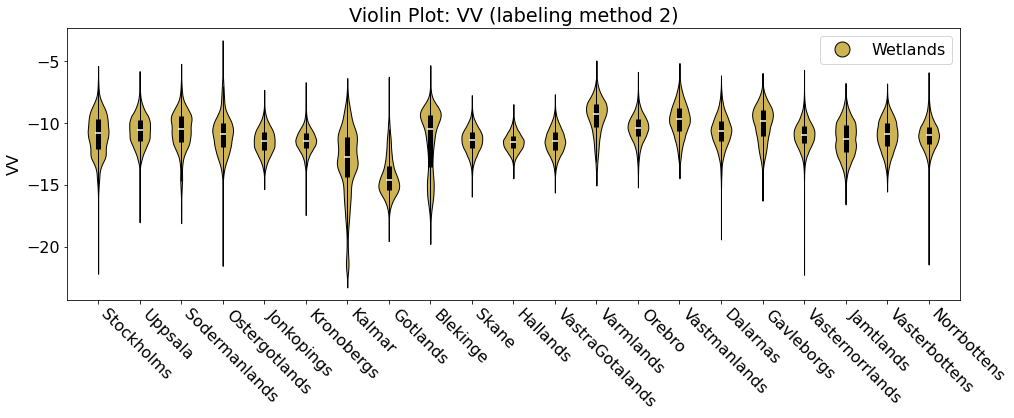

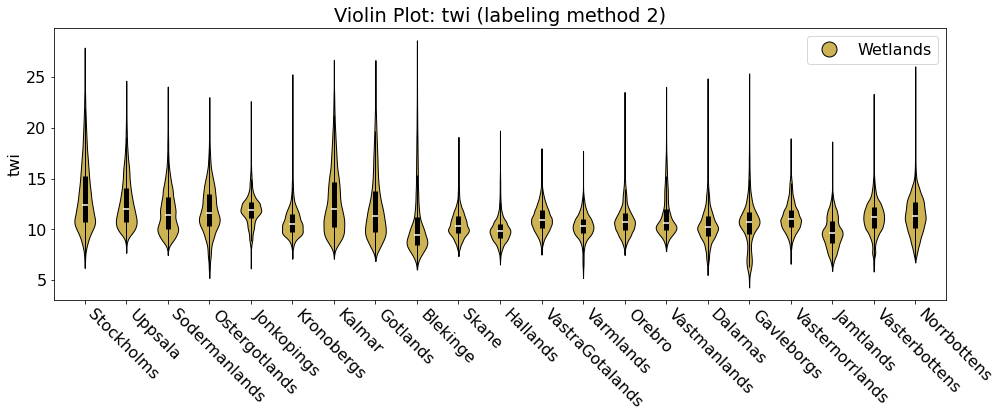

In [5]:
plot_compare_counties('VV', wetlands2, '2')
plot_compare_counties('twi', wetlands2, '2')

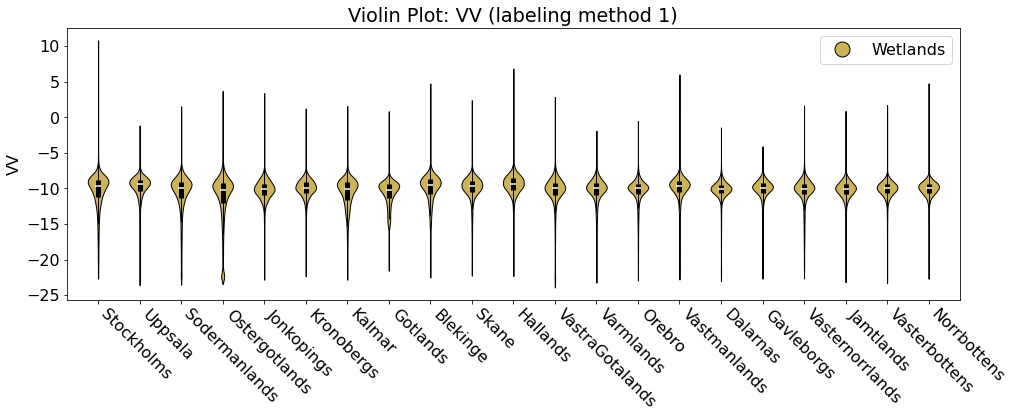

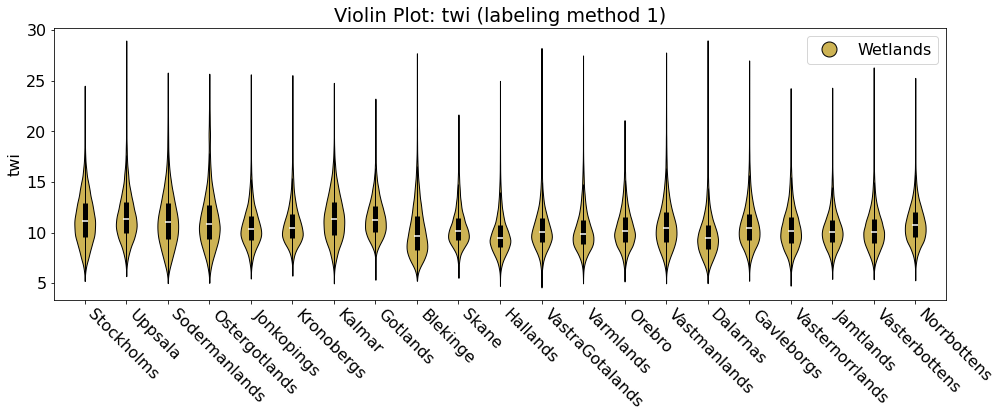

In [6]:
plot_compare_counties('VV', wetlands1, '1')
plot_compare_counties('twi', wetlands1, '1')

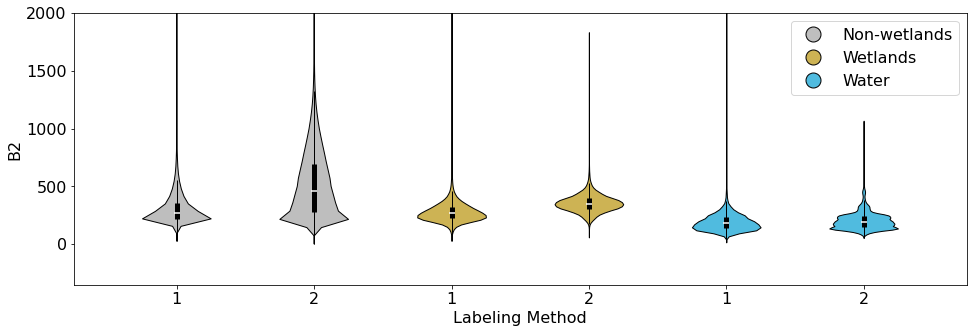

In [40]:
plot_compare_lm('B2', top=2000)

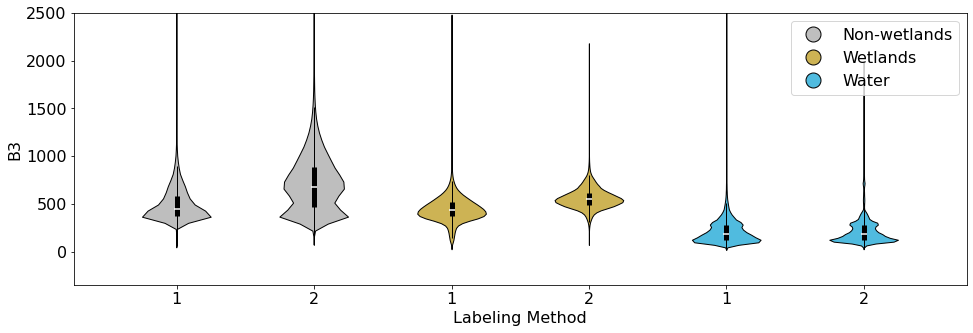

In [39]:
plot_compare_lm('B3', top=2500)

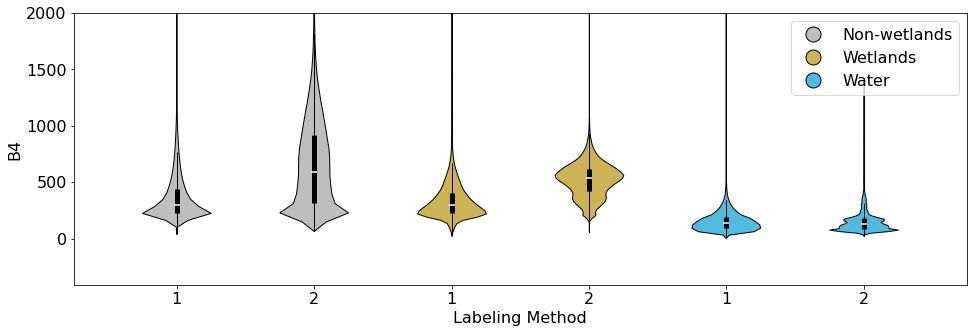

In [38]:
plot_compare_lm('B4', top=2000)

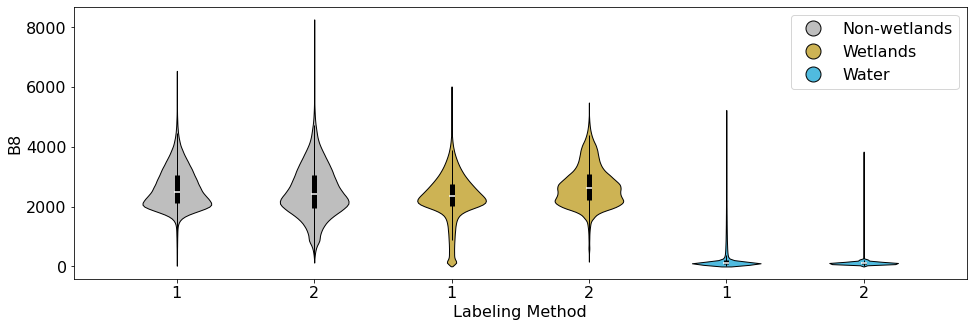

In [37]:
plot_compare_lm('B8')

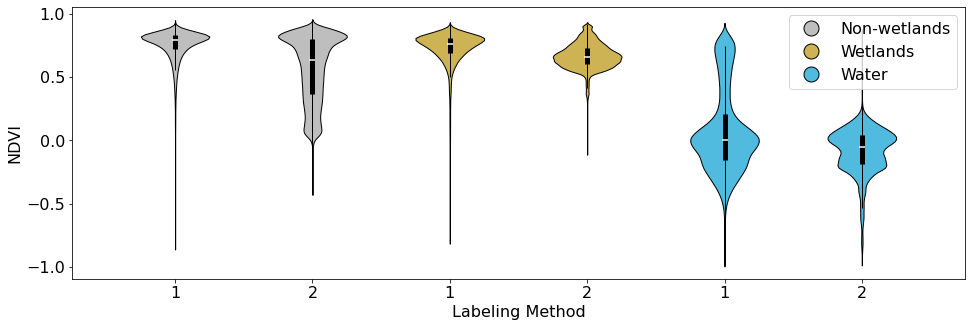

In [36]:
plot_compare_lm('NDVI')

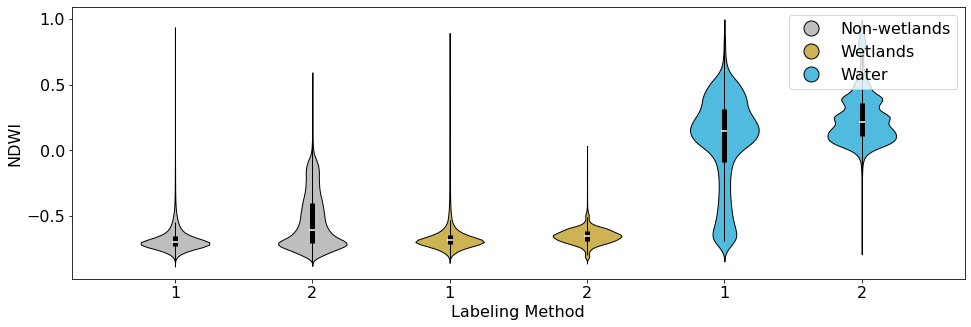

In [35]:
plot_compare_lm('NDWI')

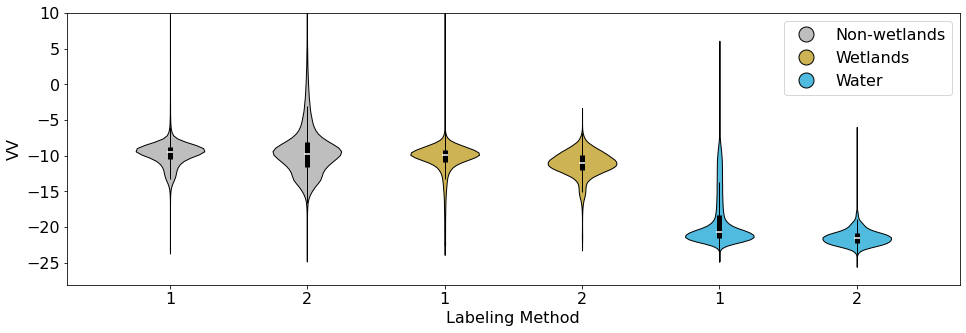

In [34]:
plot_compare_lm('VV', top=10)

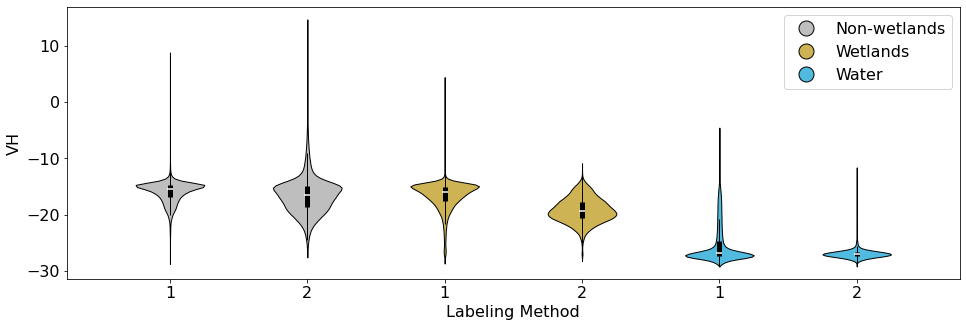

In [33]:
plot_compare_lm('VH')

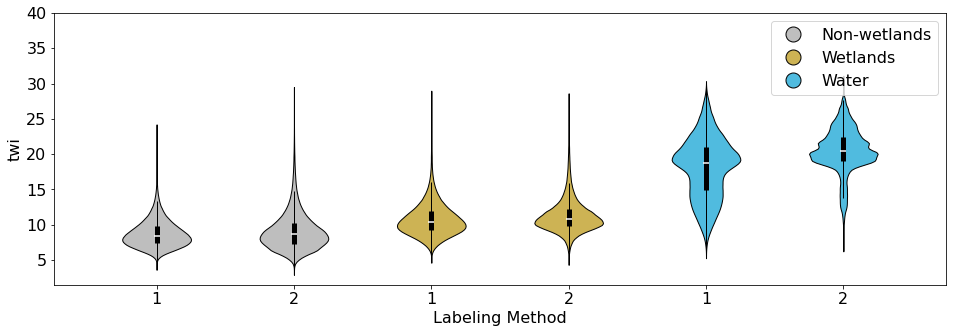

In [30]:
plot_compare_lm('twi', top=40)

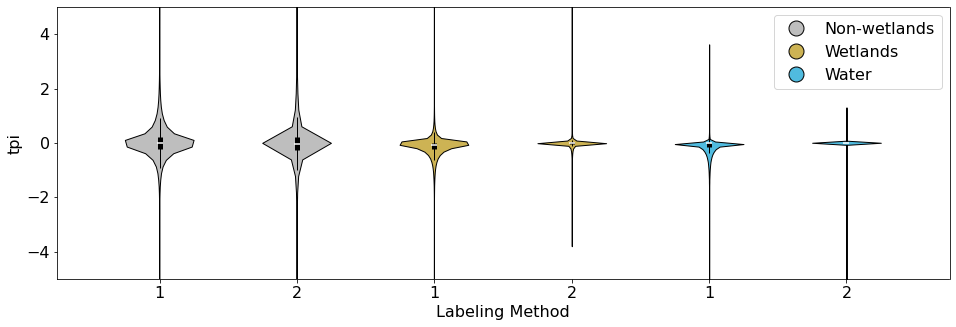

In [31]:
plot_compare_lm('tpi', top=5, bottom=-5)

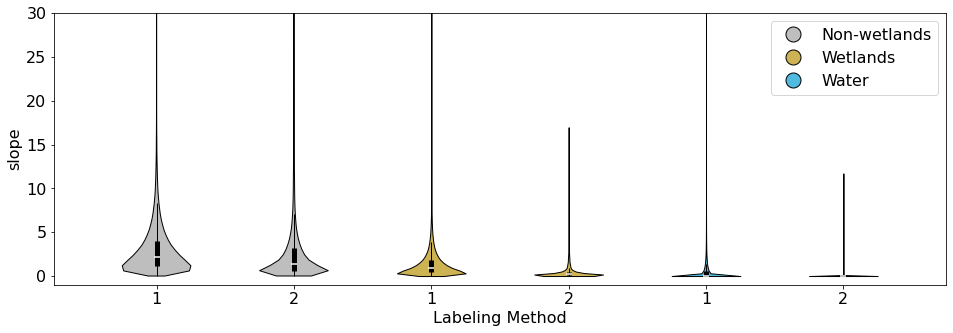

In [32]:
plot_compare_lm('slope', top=30, bottom=-1)

In [ ]:
# ATTENTION: plotly no sirve por que cada csv tiene 1,900,000 records.
#import plotly.graph_objects as go
# https://plotly.com/python/violin/

# LUCAS

In [13]:
fp = '/home/salva/proyectos/thesis/data/originals/LUCAS/SE_2018_20200213.CSV'
df = pd.read_csv(fp)

/home/salva/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3369: DtypeWarning: Columns (0,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [66]:
pd.get_option("display.max_columns")

In [65]:
pd.set_option("display.max_columns", None)

In [8]:
#pd.set_option("display.max_rows", None)  # use with care

In [14]:
df.head()

,POINT_ID,NUTS0,NUTS1,NUTS2,NUTS3,TH_LAT,TH_LONG,OFFICE_PI,EX_ANTE,SURVEY_DATE,...,SOIL_BLK_20_30_TAKEN,STANDARD_SAMPLE,SOIL_STD_TAKEN,ORGANIC_SAMPLE,SOIL_ORG_DEPTH_CANDO,PHOTO_POINT,PHOTO_NORTH,PHOTO_EAST,PHOTO_SOUTH,PHOTO_WEST
0,47924160,SE,SE1,SE12,SE121,60.285448,18.514806,1.0,0.0,20/08/18,...,8.0,0.0,8.0,0.0,8.0,2.0,2.0,2.0,2.0,2.0
1,47924546,SE,SE3,SE33,SE331,63.729598,19.516239,0.0,0.0,08/07/18,...,8.0,0.0,8.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0
2,47925046,SE,SE3,SE33,SE332,68.188886,21.298386,1.0,1.0,07/12/18,...,8.0,0.0,8.0,0.0,8.0,2.0,2.0,2.0,2.0,2.0
3,44264056,SE,SE3,SE31,SE311,59.592307,11.854797,1.0,0.0,12/10/18,...,8.0,0.0,8.0,0.0,8.0,2.0,2.0,2.0,2.0,2.0
4,43943956,SE,SE2,SE23,SE232,58.699288,11.256914,0.0,0.0,10/09/18,...,8.0,0.0,8.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0


In [19]:
df['NUTS3'].value_counts()

SE332    3418
SE322    2680
SE232    2230
SE313    2115
SE311    1904
SE224    1839
SE331    1825
SE312    1530
SE110    1350
SE123     983
SE213     825
SE211     775
SE321     766
SE124     764
SE121     760
SE212     580
SE122     565
SE231     541
SE221     472
SE125     440
SE214     347
Name: NUTS3, dtype: int64

In [32]:
df.describe()

,TH_LAT,TH_LONG,OFFICE_PI,EX_ANTE,CAR_LATITUDE,CAR_EW,CAR_LONGITUDE,GPS_PROJ,GPS_PREC,GPS_ALTITUDE,GPS_LAT,GPS_EW,GPS_LONG,OBS_DIST,OBS_DIRECT,OBS_TYPE,LC1_PERC,LC2_PERC,LU1_PERC,LU2_PERC,PARCEL_AREA_HA,TREE_HEIGHT_SURVEY,TREE_HEIGHT_MATURITY,FEATURE_WIDTH,LNDMNG_PLOUGH,LM_PLOUGH_SLOPE,LM_PLOUGH_DIRECT,LM_STONE_WALLS,CROP_RESIDUES,LM_GRASS_MARGINS,GRAZING,SPECIAL_STATUS,LC_LU_SPECIAL_REMARK,CPRN_CANDO,CPRN_LC1N,CPRNC_LC1E,CPRNC_LC1S,CPRNC_LC1W,CPRN_LC1N_BRDTH,CPRN_LC1E_BRDTH,CPRN_LC1S_BRDTH,CPRN_LC1W_BRDTH,CPRN_URBAN,CPRN_IMPERVIOUS_PERC,INSPIRE_PLCC1,INSPIRE_PLCC2,INSPIRE_PLCC3,INSPIRE_PLCC4,INSPIRE_PLCC5,INSPIRE_PLCC6,INSPIRE_PLCC7,INSPIRE_PLCC8,EUNIS_COMPLEX,GRASSLAND_SAMPLE,GRASS_CANDO,WM,WM_SOURCE,WM_TYPE,WM_DELIVERY,EROSION_CANDO,SOIL_STONES_PERC,BIO_SAMPLE,SOIL_BIO_TAKEN,BULK0_10_SAMPLE,SOIL_BLK_0_10_TAKEN,BULK10_20_SAMPLE,SOIL_BLK_10_20_TAKEN,BULK20_30_SAMPLE,SOIL_BLK_20_30_TAKEN,STANDARD_SAMPLE,SOIL_STD_TAKEN,ORGANIC_SAMPLE,SOIL_ORG_DEPTH_CANDO,PHOTO_POINT,PHOTO_NORTH,PHOTO_EAST,PHOTO_SOUTH,PHOTO_WEST
count,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,10685.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.0,26709.0,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000
mean,60.815615,15.856254,0.596690,0.053465,77.102529,5.199633,59.551364,5.180089,5333.838332,5428.439065,77.171063,5.199633,59.560836,54.293402,1.031263,4.604628,97.613164,9217.175334,106.681119,9267.004455,4.412558,4.550339,4.603242,4.591336,2.222060,7.564342,7.663110,1.367554,2.260474,1.504699,2.181137,3.735857,9.840279,6.944363,81.925156,81.916058,81.979557,81.997903,846.763338,845.699015,846.891422,847.837171,1.966229,544.558726,253.961099,237.940657,233.397207,241.474559,231.100303,226.908233,229.017073,225.718784,43.860721,0.005317,7.967314,7.229061,7.990602,7.989367,7.990340,7.422292,819.756150,0.003519,7.976375,0.031488,7.790221,0.031488,7.791306,0.0,8.0,0.052230,7.657044,0.023176,7.849040,1.607024,1.596690,1.596690,1.596690,1.596690
std,3.421197,2.629534,0.490571,0.224963,14.736729,3.429425,35.973376,3.430507,4352.687622,4293.406509,14.509338,3.429425,35.952524,581.849805,0.204496,2.920896,12.231072,27096.107062,768.313834,27160.916965,1.010708,3.029939,2.975730,2.988098,1.317273,1.665428,1.287878,1.497998,1.295476,1.546792,1.138290,0.839338,1.284151,2.471519,16.892370,16.910308,16.710566,16.670116,181.516068,183.860451,181.526949,179.388647,0.189149,426.958438,371.142002,379.833719,382.261306,378.386159,383.605454,385.888696,384.863942,386.531190,38.664664,0.072722,0.466749,1.618475,0.215527,0.236432,0.207099,1.923484,235.847004,0.059221,0.406353,0.174634,1.184551,0.174634,1.178770,0.0,0.0,0.222494,1.501391,0.150464,1.002829,0.488421,0.490571,0.490571,0.490571,0.490571
min,55.351410,11.129495,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-48.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,50.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [36]:
df.describe().columns

Index(['TH_LAT', 'TH_LONG', 'OFFICE_PI', 'EX_ANTE', 'CAR_LATITUDE', 'CAR_EW',
       'CAR_LONGITUDE', 'GPS_PROJ', 'GPS_PREC', 'GPS_ALTITUDE', 'GPS_LAT',
       'GPS_EW', 'GPS_LONG', 'OBS_DIST', 'OBS_DIRECT', 'OBS_TYPE', 'LC1_PERC',
       'LC2_PERC', 'LU1_PERC', 'LU2_PERC', 'PARCEL_AREA_HA',
       'TREE_HEIGHT_SURVEY', 'TREE_HEIGHT_MATURITY', 'FEATURE_WIDTH',
       'LNDMNG_PLOUGH', 'LM_PLOUGH_SLOPE', 'LM_PLOUGH_DIRECT',
       'LM_STONE_WALLS', 'CROP_RESIDUES', 'LM_GRASS_MARGINS', 'GRAZING',
       'SPECIAL_STATUS', 'LC_LU_SPECIAL_REMARK', 'CPRN_CANDO', 'CPRN_LC1N',
       'CPRNC_LC1E', 'CPRNC_LC1S', 'CPRNC_LC1W', 'CPRN_LC1N_BRDTH',
       'CPRN_LC1E_BRDTH', 'CPRN_LC1S_BRDTH', 'CPRN_LC1W_BRDTH', 'CPRN_URBAN',
       'CPRN_IMPERVIOUS_PERC', 'INSPIRE_PLCC1', 'INSPIRE_PLCC2',
       'INSPIRE_PLCC3', 'INSPIRE_PLCC4', 'INSPIRE_PLCC5', 'INSPIRE_PLCC6',
       'INSPIRE_PLCC7', 'INSPIRE_PLCC8', 'EUNIS_COMPLEX', 'GRASSLAND_SAMPLE',
       'GRASS_CANDO', 'WM', 'WM_SOURCE', 'WM_TYPE', 'WM_DELIV

In [14]:
not_numerical = [_ for _ in df.columns if _ not in df.describe().columns] # if var in describe = is numerical

In [18]:
not_numerical

['POINT_ID',
 'NUTS0',
 'NUTS1',
 'NUTS2',
 'NUTS3',
 'SURVEY_DATE',
 'LC1',
 'LC1_SPEC',
 'LC2',
 'LC2_SPEC',
 'LU1',
 'LU1_TYPE',
 'LU2',
 'LU2_TYPE',
 'CPRN_LC',
 'CPRN_LC1N_NEXT',
 'CPRN_LC1E_NEXT',
 'CPRN_LC1S_NEXT',
 'CPRN_LC1W_NEXT']

In [16]:
df[not_numerical].head()

,POINT_ID,NUTS0,NUTS1,NUTS2,NUTS3,SURVEY_DATE,LC1,LC1_SPEC,LC2,LC2_SPEC,LU1,LU1_TYPE,LU2,LU2_TYPE,CPRN_LC,CPRN_LC1N_NEXT,CPRN_LC1E_NEXT,CPRN_LC1S_NEXT,CPRN_LC1W_NEXT
0,47924160,SE,SE1,SE12,SE121,20/08/18,C33,C331,8,8,U120,8,8,8,8,8,8,8,8
1,47924546,SE,SE3,SE33,SE331,08/07/18,E20,8,8,8,U111,8,8,8,E2,C3,C3,8,8
2,47925046,SE,SE3,SE33,SE332,07/12/18,C32,C321,8,8,U350,8,8,8,8,8,8,8,8
3,44264056,SE,SE3,SE31,SE311,12/10/18,C21,C211,8,8,U120,8,8,8,8,8,8,8,8
4,43943956,SE,SE2,SE23,SE232,10/09/18,B53,B53k,8,8,U111,8,8,8,8,8,8,8,8


In [71]:
# LUCAS2018-C3-Classification.pdf : 
# H10:  inland wetlands. H11: inland marshes (N=533). H12: peatbogs (N=2,465)
# H20: coastal wetlands. H21: salt marshes (N=2)
# GXX: water
df['LC1'].value_counts() 

C22    3413
C21    3070
C31    2535
H12    2465
E20    2359
C32    1907
C10    1816
D20     966
Bx1     799
C33     700
C23     579
A22     560
E10     548
H11     533
F30     476
D10     475
B11     475
B55     372
B13     353
E30     325
B53     264
A21     246
A11     244
F40     233
G11     158
B15     143
B32     130
A30      93
F10      89
B41      45
B22      44
B14      43
G21      40
B51      35
B21      33
F20      28
B16      18
A12      14
B71      13
B43       9
B84       8
B54       7
B35       6
B52       6
B23       4
B45       4
B75       4
B12       3
G12       3
H21       2
B44       2
8         2
B19       2
A13       2
G50       2
B18       1
B31       1
Bx2       1
B73       1
Name: LC1, dtype: int64

In [2]:
df['SURVEY_DATE'].value_counts()

24/10/18    706
25/10/18    562
23/10/18    514
15/10/18    453
16/10/18    429
           ... 
27/05/18      6
20/05/18      6
16/04/18      2
26/05/18      2
21/11/18      1
Name: SURVEY_DATE, Length: 208, dtype: int64

In [94]:
df['OBS_TYPE'].value_counts()

7.0    15935
1.0    10390
3.0      276
2.0      106
5.0        2
Name: OBS_TYPE, dtype: int64

In [32]:
def df_reclass(row):
    if type(row['LC1']) == str:
        if 'H' in row['LC1']:
            return 2
        elif 'G' in row['LC1']:
            return 3
        else: 
            return 1
    else:
        return 0

df['reclass'] = df.apply(lambda row: df_reclass(row), axis=1)

# wetlands: the three following LC1 classes altogether sum 3000 samples
#H11 = df[df['LC1']=='H11']
#H12 = df[df['LC1']=='H12']
#H21 = df[df['LC1']=='H21'] 

In [93]:
df[df['reclass']==2]['NUTS3'].value_counts() # wetlands occurrence: 2,309/3,000 in AC, BD & Z (77%)

SE332    1250
SE331     539
SE322     520
SE312     160
SE232      82
SE321      74
SE313      58
SE311      51
SE124      42
SE211      40
SE231      28
SE212      27
SE213      24
SE121      21
SE123      19
SE125      16
SE110      15
SE224      14
SE122      12
SE214       5
SE221       3
Name: NUTS3, dtype: int64

In [99]:
df[df['reclass']==2]['OBS_TYPE'].value_counts()

7.0    2813
1.0     170
3.0      17
Name: OBS_TYPE, dtype: int64

In [106]:
l = ['C22', 'C32', 'C21', 'C31', 'C10', 'C33', 'C23', 'D20', 'D10', 'E20', 'E10', 'E30']
l_mask = (df['LC1']==l[0])|(df['LC1']==l[1])|(df['LC1']==l[2])|(df['LC1']==l[3])|(df['LC1']==l[4])|(df['LC1']==l[5])|(df['LC1']==l[6])|(df['LC1']==l[7])|(df['LC1']==l[8])|(df['LC1']==l[9])|(df['LC1']==l[10])|(df['LC1']==l[11])
print(df[l_mask]['OBS_TYPE'].value_counts())
print('sum:',10902+7522+231+38)

7.0    10902
1.0     7522
3.0      231
2.0       38
Name: OBS_TYPE, dtype: int64
sum: 18693


In [110]:
what_I_want = ['TH_LAT', 'TH_LONG','reclass', 'NUTS3']
df[what_I_want].to_csv('LUCAS2018_reclass.csv')

In [73]:
# the reclassification (^) needs to be added to qgis from a csv, and used to extract raster values from lm1 & lm2:

fp = '/home/salva/proyectos/thesis/data/originals/LUCAS/LUCAS2018_reclass_classification.csv'
df2 = pd.read_csv(fp, index_col='field_1')#.dropna() it was breaking stuff, use it directly and only in matrices
df2.index.name = None

print(df2.describe())

             TH_LAT       TH_LONG       reclass       V2lm2_1       V2lm1_1
count  26709.000000  26709.000000  26710.000000  26709.000000  26709.000000
mean      60.815615     15.856254      1.127480      1.157026      1.266727
std        3.421197      2.629534      0.355681      0.379349      0.472623
min       55.351410     11.129495      0.000000      0.000000      0.000000
25%       58.222022     13.732809      1.000000      1.000000      1.000000
50%       59.943984     15.596304      1.000000      1.000000      1.000000
75%       63.346683     17.330397      1.000000      1.000000      2.000000
max       69.043090     24.140906      3.000000      3.000000      3.000000


In [74]:
df2.head()

,TH_LAT,TH_LONG,reclass,NUTS3,V2lm2_1,V2lm1_1
0,60.285448,18.514806,1,SE121,1.0,1.0
1,63.729598,19.516239,1,SE331,1.0,1.0
2,68.188886,21.298386,1,SE332,1.0,1.0
3,59.592307,11.854797,1,SE311,1.0,2.0
4,58.699288,11.256914,1,SE232,1.0,1.0


In [75]:
print([df[df['reclass'] == _].shape for _ in [1,2,3]])

[(23506, 98), (3000, 98), (203, 98)]


In [78]:
cm_lm1 = confusion_matrix(df2.dropna()['reclass'], df2.dropna()['V2lm1_1'])
print(cm_lm1)
overall1, producers1, users1, K1 = stats(cm_lm1)
print(overall1, K1)
print(producers1, users1)

[[    0     0     0     0]
 [   26 19148  4217   115]
 [    0   642  2291    67]
 [   25    13    27   138]]
0.8078550301396533 0.3993701182407612
[0.8146005275248872, 0.7636666666666667, 0.6798029556650246] [0.9669242034035247, 0.35057383320581487, 0.43125]


In [79]:
cm_lm2 = confusion_matrix(df2.dropna()['reclass'], df2.dropna()['V2lm2_1'])
print(cm_lm2)
overall2, producers2, users2, K2 = stats(cm_lm2)
print(overall2, K2)
print(producers2, users2)

[[    0     0     0     0]
 [   26 21414  2063     3]
 [    0  1037  1961     2]
 [   25    65    15    98]]
0.8788423377887603 0.49741535344459864
[0.911001446439207, 0.6536666666666666, 0.4827586206896552] [0.9510570261147628, 0.48551621688536767, 0.9514563106796117]


a 'wrong' attribute is created to know WHERE are this misclassifications, 

wrong == 1 if a LUCAS wetland (reclass==2) is classified as a non-wetland (V2lm2_1==1)

wrong == 2 if a LUCAS non-wetland (reclass==1) is classified as a wetland (V2lm2_1==2)

raster calculator (QGIS):

if(attribute('reclass')=2,if(attribute('V2lm2_1')=1,1,0),if(attribute('reclass')=1,if(attribute('V2lm2_1')=2,2,0),0))

In [ ]:
# after answering where, want to know what LC1 class are being missclasified??

In [83]:
# wrong 1 (1,037 values)
df[(df2['V2lm2_1']==1)&(df2['reclass']==2)]['LC1'].value_counts() # == df.loc[()&()]

H12    756
H11    279
H21      2
Name: LC1, dtype: int64

In [85]:
# wrong 2 (2,063 values)
df[(df2['V2lm2_1']==2)&(df2['reclass']==1)]['LC1'].value_counts() # == df.loc[()&()]

C22    360
C32    234
E20    228
D20    221
C21    134
C31    127
C10    126
Bx1    117
D10     98
F30     89
E10     42
C33     35
B55     35
C23     33
B11     25
B53     24
F40     24
E30     23
B13     23
A30     15
B15     10
A22      8
B32      8
F10      4
A11      3
B41      3
B22      3
B21      3
B14      2
A21      2
F20      1
B23      1
B16      1
Bx2      1
Name: LC1, dtype: int64

In [86]:
df[(df2['V2lm2_1']==2)&(df2['reclass']==1)]['LC1'].value_counts().to_numpy().sum()

2063

In [101]:
print(sum([360,234,134,127,126,35,33]), 1049/2063) # C22, C32, C21, C31, C10, C33, C23 # woodlands: Areas covered by trees with a canopy of at least 10%. Also woody hedges and palm trees are included in this class.
print(221+98, 319/2063) # D20 & D10 # shrublands, 
print(228+42+23, 293/2063)# E20, E10, E30 # grassland, 
print(89+24+4+1, 118/2063) # bah

1049 0.508482792050412
319 0.1546291808046534
293 0.1420261754726127
118 0.057198254968492485


# GSD2

In [6]:
!echo 'stockholms_gsd2+'
!pkstat -i /home/salva/proyectos/thesis/data/rasters/Stockholms_run89789_lm2_classified10_gsd2.tif -hist -nbins 4

!echo RFWI_stockholmss
!pkstat -i /home/salva/proyectos/thesis/data/rasters/RFWI_stockholms.tif -hist -nbins 4

!echo 'jatmlands_gsd2+'
!pkstat -i /home/salva/proyectos/thesis/data/rasters/Jamtlands_run89825_lm2_classified10_gsd2.tif -hist -nbins 4

!echo RFWI_jatmlands
!pkstat -i /home/salva/proyectos/thesis/data/rasters/RFWI_jatmlands.tif -hist -nbins 4


stockholms_gsd2+
0 914080
1 8780759
2 184640
3 2367038
RFWI_stockholmss
0 398364
1 8248635
2 750806
3 1977195
jatmlands_gsd2+
0 1173025
1 11296843
2 2351365
3 475621
RFWI_jatmlands
0 5991
1 8148387
2 5503061
3 472381


In [9]:
print('stockholms_gsd2', 8780759+184640+2367038, 'wetlands [km2]:', 184640*10*10/1000000)
print('stockholms_RFWI', 8248635+750806+1977195, 'wetlands [km2]:', 750806*10*10/1000000)

# que sea distinto en stockholm tiene sentido! hay una parte del mar que es no-data en RFWI por oversiktskartan...

print('jamtlands_gsd2', 11296843+2351365+475621, 'wetlands [km2]:', 2351365*10*10/1000000)
print('jamtlands_RFWI', 8148387+5503061+472381, 'wetlands [km2]:', 5503061*10*10/1000000)

stockholms_gsd2 11332437 wetlands [km2]: 18.464
stockholms_RFWI 10976636 wetlands [km2]: 75.0806
jamtlands_gsd2 14123829 wetlands [km2]: 235.1365
jamtlands_RFWI 14123829 wetlands [km2]: 550.3061


# ESA LC

In [12]:
# same as MODIS, ESA LC was clipped usnig 'clip raster by mask layer' in QGIS, then we have a tif per county
modis_dict_lanskod = {0:19,1:10,2:5,3:3,4:22,5:12,6:21,7:23,8:25,9:1,10:4,11:7,12:13,13:9,14:14,15:8,16:20,17:24,18:17,19:6,20:18}
fp = "/home/salva/proyectos/thesis/data/rasters/ESALC_per_county/"
l1 = pathlib.Path(fp).glob('*.tif')

output_df = pd.DataFrame()

for f in l1:
    lanskod = modis_dict_lanskod[int(f.stem.split('_')[1])]
    county = counties_str[lanskod]
    print(f.stem, county)
    output = subprocess.check_output('pkstat -i ' + str(f) + ' -hist -nbins 4', shell=True) # no servia de llamandolo tipo !pkstat, os.system tambien sirve pero no retreive el resultado
    out_str = str(output).split("'")[1]
    
    out_array = np.array([_.split(' ') for _ in out_str.split('\\n')[:-1]]+[['999', f.stem.split('_')[1]]]) # 999 = raster #
    if out_array[:,1].size == 92:
        output_df = pd.concat([output_df, pd.DataFrame([out_array[:,1]], index = [county], columns = [_ for _ in range(91)]+['raster_n'])])
        print('OK')
    else: 
        print(out_array)
    print('')
    #break

output_df['lanskod'] = output_df.apply(lambda row: counties_num[row.name], axis=1)

#output_df['valid'] = output_df[]
print(output_df)
output_df.to_csv('pixelcount_' + pathlib.Path(fp).stem + '.csv')

# regex ^.{1,}'0']$\n

raster_3 Uppsala
OK

raster_0 Vastmanlands
OK

raster_19 Jonkopings
OK

raster_9 Stockholms
OK

raster_16 Dalarnas
[['0' '817881866']
 ['1' '0']
 ['2' '0']
 ['3' '0']
 ['4' '0']
 ['5' '0']
 ['6' '0']
 ['7' '0']
 ['8' '0']
 ['9' '0']
 ['10' '524855442']
 ['11' '0']
 ['12' '0']
 ['13' '0']
 ['14' '0']
 ['15' '0']
 ['16' '0']
 ['17' '0']
 ['18' '0']
 ['19' '0']
 ['20' '1004183']
 ['21' '0']
 ['22' '0']
 ['23' '0']
 ['24' '0']
 ['25' '0']
 ['26' '0']
 ['27' '0']
 ['28' '0']
 ['29' '0']
 ['30' '87763201']
 ['31' '0']
 ['32' '0']
 ['33' '0']
 ['34' '0']
 ['35' '0']
 ['36' '0']
 ['37' '0']
 ['38' '0']
 ['39' '0']
 ['40' '12225089']
 ['41' '0']
 ['42' '0']
 ['43' '0']
 ['44' '0']
 ['45' '0']
 ['46' '0']
 ['47' '0']
 ['48' '0']
 ['49' '0']
 ['50' '2043530']
 ['51' '0']
 ['52' '0']
 ['53' '0']
 ['54' '0']
 ['55' '0']
 ['56' '0']
 ['57' '0']
 ['58' '0']
 ['59' '0']
 ['60' '2759769']
 ['61' '0']
 ['62' '0']
 ['63' '0']
 ['64' '0']
 ['65' '0']
 ['66' '0']
 ['67' '0']
 ['68' '0']
 ['69' '0']
 ['70' 

OK

raster_18 Varmlands
OK

                         0  1  2  3  4  5  6  7  8  9  ... 83 84 85 86 87 88  \
Uppsala          193859805  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Vastmanlands      92811150  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Jonkopings       247407644  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Stockholms       361747726  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Ostergotlands    241879641  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Hallands         230369212  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Sodermanlands    150641477  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Kalmar           291683506  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Blekinge          74713001  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
VastraGotalands  523424299  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Kronobergs       128923615  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
Orebro      

In [9]:
out_array[:,1].shape

(92,)

In [11]:
asdasdasd = [_ for _ in range(92)]+['hola']
print(len(asdasdasd))

93


In [14]:
#ATTENTION: bash code

#lets check if every raster has the same resolution

!for i in /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/*.tif; do gdalinfo $i | grep -E 'Files|Pixel'; done

Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_0.tif
Pixel Size = (6.666774287938114,-6.667035014263002)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_10.tif
Pixel Size = (6.666933192773803,-6.666818927630882)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_11.tif
Pixel Size = (6.667030176826155,-6.667055325770892)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_12.tif
Pixel Size = (6.666987440861660,-6.666864933613296)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_13.tif
Pixel Size = (6.666967143997545,-6.666919877900866)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_14.tif
Pixel Size = (6.666947572932112,-6.666980263112612)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_15.tif
Pixel Size = (6.667108616645439,-6.666972845558434)
Files: /home/salva/proyectos/thesis/data/rasters/ESALC_per_county/raster_16.t

# Others

In [7]:
# mahdianpari 
samples = [ 659, 792, 702, 797, 862, 793, 816, 521, 296, 1072, 625, 478, 491]
sum(samples)

8904